# Pytorch

Pytorch provides modules and classes

torch.nn, torch,optim, Dataset, and DataLoader

to help create and train neural networks

First we will train a basic neural not on mnist without using any features from these models

We will later add functionality from each of the previous

In [1]:
from pathlib import Path
import requests

#create a path object so we can call things like mkdir
DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

# this will create a new directory at the given path
PATH.mkdir(parents=True, exist_ok=True)

In [2]:
# ok so we know our data folder now contains
# a folder called mnist
!ls data/

mnist


In [3]:
# Now let's get the data

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

# if the file does not already exist
if not (PATH/FILENAME).exists():
    # put the content of the download in a variable
    content = requests.get(URL+FILENAME).content
    # open the path and write the content
    (PATH/FILENAME).open('wb').write(content)

In [4]:
# great so now mnist contains our dataset
# The data set is in numpy array format
# It has been stored using pickle, a python-specific format for serializing data
# also its been gzipped
!ls data/mnist/

mnist.pkl.gz


In [5]:
# we need these libs to deal with the compression
import pickle
import gzip


f = gzip.open(PATH/FILENAME)

((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
# these images are being stored as a flattened row of length 784 or 28x28
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

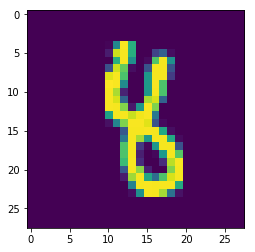

In [7]:
# lets see them in 2d
%matplotlib inline

from matplotlib import pyplot
import numpy as np

img = x_train[7000].reshape(28,28)

pyplot.imshow(img)

In [8]:
# pytorch uses a torch.tensor rather than numpy arrays
x_train.dtype

dtype('float32')

In [42]:
# so the elements must first be converted
import torch
# convert our data to torch tensors
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape

In [11]:
x_train.type, x_train.shape

(<function Tensor.type>, torch.Size([50000, 784]))

## Neural net from scratch

First we will create a model using nothing but pytorch tensor operations

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set requires_grad after the initialization, since we don't want that step included in the gradient. (Note that a trailing _ in PyTorch signifies that the operation is performed in-place.)

NB: We are initializing the weights here with [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (by multiplying with 1/sqrt(n)).

In [17]:
# we need sqrt from math
from math import sqrt

# lets initalize our weights which will be random initally
weights = torch.randn(784,10)/math.sqrt(784)
weights.shape

torch.Size([784, 10])

In [24]:
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
bias

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)



Thanks to PyTorch's ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let's just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we'll write log_softmax and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.


In [21]:
def log_softmax(x): 
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):      
    return log_softmax(xb @ weights + bias)



In the above, the '@' stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won't be any better than random at this stage, since we start with random weights.


In [22]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-2.5238, -2.6042, -1.8414, -2.2044, -2.4944, -2.4332, -2.2051, -2.4190,
         -2.2444, -2.2884], grad_fn=<SelectBackward>), torch.Size([64, 10]))



As you see, the preds tensor contains not only the tensor values, but also a gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss function (again, we can just use standard Python):


In [44]:
def nll(input, target): 
    return -input[range(target.long().shape[0]), target.long()].mean()

loss_func = nll



Let's check our loss with our random model, so we can see if we improve after a backprop pass later.


In [45]:
yb = y_train[0:bs].long()
loss_func(preds, yb)

tensor(2.2800, grad_fn=<NegBackward>)



Let's also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.


In [46]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

In [47]:
accuracy(preds, yb)

tensor(0.1250)

In [48]:
from IPython.core.debugger import set_trace

lr = 0.5   # learning rate
epochs = 2 # how many epochs to train for

In [49]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [51]:
loss_func(model(xb), yb), accuracy(model(xb), yb.long())

(tensor(0.0796, grad_fn=<NegBackward>), tensor(1.))